# Code to solve Euler equations

$ ∂_t \rho + v \partial_x \rho + \rho \partial_x v = 0$

$ v ∂_t \rho + \rho \partial_t v + v \partial_x \rho v  + \partial_x P = 0$

$ \partial_t e + v \partial_x e + \frac{P}{\rho} \partial_x v = 0 $

where we need an equation of state

$P(\rho, e)$

We can assume in

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from sympy import init_printing

init_printing(use_latex=True)
plt.rcParams['text.usetex'] = True

In [ ]:
def getConserved( rho, vx, P, gamma, vol ):
	"""
    Calculate the conserved variable from the primitive
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	P        is matrix of cell pressures
	gamma    is ideal gas gamma
	vol      is cell volume
	Mass     is matrix of mass in cells
	Momx     is matrix of x-momentum in cells
	Energy   is matrix of energy in cells
	"""
	Mass   = rho * vol
	Momx   = rho * vx
	Energy = (P/(gamma-1) + 0.5*rho*(vx**2))

	return Mass, Momx, Energy


In [ ]:
def Isentropic(rho, Momx, E, gamma):
  P = rho**gamma
  return P

def Ideal(rho, Momx, E, gamma):
  P = (gamma-1)*(E - 0.5*(Momx**2 / rho))
  return P

In [ ]:
def getPrimitive( Mass, Momx, E, gamma, vol, Eos = Isentropic):
  """
  Calculate the primitive variable from the conservative
  Mass     is matrix of mass in cells
  Momx     is matrix of x-momentum in cells
  E        is matrix of Energy in cells

  gamma    is ideal gas gamma
  vol      is cell volume
  rho      is matrix of cell densities
  vx       is matrix of cell r-velocity
  P        is matrix of cell pressures
  """
  rho = Mass / vol
  vx  = np.divide(Momx , rho, out=np.zeros_like(Momx), where=rho!=0)
  e   = E - rho*vx**2 / 2
  P   = Eos(rho, Momx, E, gamma)

  return rho, vx, e,P

def getPressure(rho, Momx, E, gamma, Eos = Isentropic):

  P = Eos(rho, Momx, E, gamma)

  return P

In [ ]:
def getSpeedOfSound(rho, P, gamma):

  cs = np.sqrt(gamma*P/rho)

  return cs

In [ ]:
def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))

def minmod(a, b, c):

	# check whether a, b, and c are the same sign
	signs = ((np.sign(a)==np.sign(b)) & (np.sign(b)==np.sign(c)) & (np.sign(c)==np.sign(a)))

	# compute minimum magnitudes of {a,b,c}
	vals = np.concatenate((a,b,c), axis=1)
	mins = np.amin(np.abs(vals), axis=1)

	# compute the minmod
	m = signs*np.sign(a)*np.reshape(mins,(len(vals),1))

	return m

In [ ]:
def getGradient(f, dx, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter

    """
    # directions for np.roll()
    R = -1   # right
    L = 1    # left

    df_dx = minmod3( theta * ( f - np.roll(f,L,axis=0) )/dx, (np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx),theta * ( np.roll(f,R,axis=0) - f ) / dx)

    return df_dx


def local_propagation_speed(rho, vx, E, gamma, Eos = Isentropic):
   '''
    rho          is a matrix of density
    vx           is a matrix of x-velocity
    vx           is a matrix of x-velocity
    cs           is the speed of sound
    '''

   P = getPressure(rho, rho*vx, E, gamma, Eos)

   cs = getSpeedOfSound(rho, P, gamma)

   C = np.abs(vx) + cs

   return C



In [ ]:
def Euler(q , C , dt):
    '''
    Foward Euler timestep

    '''
    E = q + dt * C

    return E

def modified_RungeKutta(q, C, dt, s=2):

    bl = 1/2

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty([s,A,B])
    except:
      y = np.empty([s,A])

    y[0:] = Euler(q,C,dt) # foward euler step

    for i in range(s):
        y[i] = bl * q + (1 - bl)*Euler(y[i-1],C,dt)

    return y[s-1]


In [ ]:
def extrapolateInSpaceToFace(q, q_dx, dx):
  """
  Calculate the gradients of a field
  q        is a matrix of the field
  q_dx     is a matrix of the field x-derivatives
  dx       is the cell size
  q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
  q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
  """
  # directions for np.roll()
  R = -1   # right
  L = 1    # left

  qP_XL = q - q_dx * dx/2
  qP_XR = np.roll(q,R,axis=0) - np.roll(q_dx,R,axis=0) * dx/2
  qM_XR = q + q_dx * dx/2
  qM_XL = np.roll(q,L,axis=0) + np.roll(q_dx,L,axis=0) * dx/2

  return qM_XL, qP_XL, qM_XR, qP_XR

In [ ]:
def getFlux(rho_P, rho_M, vx_P, vx_M, P_P, P_M, gamma, Eos = Isentropic):
  """
  Calculate fluxed between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  Eos          is the equation of state for pressure Eos(rho, Momx, E, gamma)
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  """

  if Eos == Isentropic:
    E_M = 0
    E_P = 0
  elif Eos == Ideal:
    E_M = P_M/(gamma-1)+0.5*rho_M * (vx_M**2)
    E_P = P_P/(gamma-1)+0.5*rho_P * (vx_P**2)



  # compute av (averaged) states
  rho_av  = 0.5*(rho_P + rho_M)
  momx_av = 0.5*(rho_P * vx_P + rho_M * vx_M)
  E_star   = 0.5*(E_M + E_P)



  # Pressure equation of state

  P_av = (Eos(rho_P, rho_P*vx_P, E_P, gamma) + Eos(rho_M, rho_M*vx_M, E_M, gamma))*0.5

  # compute fluxes (local Rusanov)

  flux_Mass   =  momx_av
  flux_Momx   = ((rho_P)*(vx_P)**2 + (rho_M)*(vx_M)**2) / 2 + P_av

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vx_P, E_P, gamma, Eos) # max propagation speed from the left

  C_M = local_propagation_speed(rho_M , vx_M, E_M, gamma, Eos) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)

  if Eos == Isentropic:
    return flux_Mass, flux_Momx, 0

  elif Eos == Ideal:
    flux_Energy = 0.5*(vx_P*E_P+vx_M*E_M) + 0.5*(vx_P*P_P+vx_M*P_M)
    flux_Energy -= C * 0.5 * (E_P - E_M)

    return flux_Mass, flux_Momx, flux_Energy




In [ ]:
def applyFluxes(flux_HRight_X, flux_HLeft_X , dx, J = 0):
    """
    Apply fluxes to conserved variables

    flux_HRight_X is a matrix of the x-dir fluxes
    flux_HLeft_X  is a matrix of the x-dir fluxes
    dx            is the cell size
    C             is the d/dt(q) of the conserved variable
    """

    C = 0

    # update solution
    C -= (flux_HRight_X - flux_HLeft_X ) / dx
    C += J

    return C

Euler


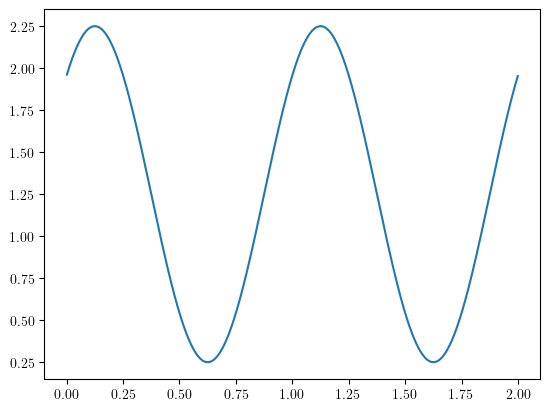

time 0.25001779900281507


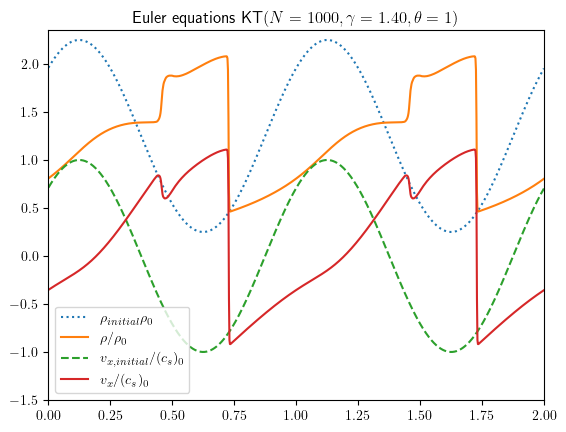

In [ ]:
def main():
    """ Finite Volume simulation """

    # Simulation parameters
    N                      = 1000  # resolution
    boxsize                = 2.   # in some unit system l
    gamma                  = 1.4
    t                      = 0    # s
    tEnd                   = 0.25    # time at the end
    # tEnd  = 2
    tOut                   = 0.01  # time of each output
    plotRealTime           = False # switch on for plotting as the simulation goes along
    fluxlimiter            = 1     # from 1 most dissipative to 2 least dissivative

    #test parameters
    flimit                 = 10**4  # Warns if fluxes are larger than this value
    runFluxLimitTests      = False  # Switch to conduct tests

    a = 0  #count

    #-----------------------------------------------------------------------------------------------------------------------------------#

    #Define
    Rho = []

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Define Mesh
    dx = boxsize / N   # box size
    vol = dx**2        # volume of each box
    xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N, dtype=np.float64 ) # simulation limits


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions


    #rho = np.zeros(X.shape)
    #rho = ((1 - ((xlin-(0.5*10-dx))**2) )**3)*(xlin>4)*(xlin<6) + 0.125*np.ones(xlin.shape)# Mauricio`s funtion advice
    #rho = 1*(xlin <= boxsize*0.5) + 0.125*(xlin > boxsize*0.5)
    rho = (np.sin(2*np.pi*xlin) + np.cos(2*np.pi*xlin))/np.sqrt(2) + 1.25*np.ones(xlin.shape)
    #rho = np.exp(-(xlin - boxsize*0.5 + dx*0.5)**2)
    plt.plot(xlin,rho)
    plt.show()
    if np.any(rho < 0):
          print("Warning: initial negative density")
    rhoic = rho

    #vx = ((xlin - (boxsize-0.5*dx)*0.5)**2/16)
    vx = (np.sin(2*np.pi*xlin) + np.cos(2*np.pi*xlin))/np.sqrt(2)
    vxic = vx

    # choose Equation of State
    Eos = Isentropic

    if Eos == Isentropic:
      P  = Eos(rho, rho*vx, 0, gamma)
      Pic = P
    elif Eos == Ideal:
      P = 2.5*np.ones(xlin.shape)

    cs = getSpeedOfSound(rho,P,gamma)


    #-----------------------------------------------------------------------------------------------------------------------------------#


    # Get conserved variables
    Mass, Momx, E = getConserved( rho, vx, P, gamma, vol)

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # prep figure

    #fig = plt.figure(figsize=(4,4), dpi=80)
    #ax = fig.add_subplot(111)

    outputCount = 1

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # Simulation Main Loop
    while t < tEnd:

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get Conserved variables
        Mass, Momx, E  = getConserved(rho, vx, P, gamma, vol)

        if np.any(Mass < 0):
          print("Mass is negative")

        # get primitive variables
        rho, vx,_, P = getPrimitive(Mass,Momx,E,gamma,vol,Eos)




        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get mean values (to plot)
        #
        #time[a] = t
        #rho_mean[a] = t

        cs = getSpeedOfSound(rho, P, gamma)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # get time step

        dt = min(tOut , 0.1*(dx / max(local_propagation_speed(rho, vx, E, gamma, Isentropic))))

        plotThisTurn = False

        if t + dt > outputCount*tOut:
            plotThisTurn = True

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # calculate gradients

        rho_dx = getGradient(rho, dx, fluxlimiter)
        vx_dx  = getGradient(vx,  dx, fluxlimiter)
        P_dx   = getGradient(P,   dx, fluxlimiter)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # extrapolate in space to face centers

        rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx)
        vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,  dx)
        PM_XL,   PP_XL,   PM_XR,   PP_XR   = extrapolateInSpaceToFace(P,   P_dx,   dx)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # compute fluxes (local Kurganov-Tadmor)

        flux_Mass_XR, flux_Momx_XR, flux_Energy_XR = getFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR, PP_XR, PM_XR, gamma, Eos)
        flux_Mass_XL, flux_Momx_XL, flux_Energy_XL = getFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL, PP_XL, PM_XL, gamma, Eos)

        # tests for flux limitation
        if runFluxLimitTests:
          print(np.all(flux_Mass_XR > flimit), np.all(flux_Momx_XR > flimit))
          print(np.all(flux_Mass_XL > flimit), np.all(flux_Momx_XL > flimit))

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update solution

        # applyFluxes(Flux from the right, flux from the left, dx) = C[q "conserved field"]
        # modified_RungeKutta(q "conserved field", C[q], dt)

        rho   = modified_RungeKutta(rho,  applyFluxes( flux_Mass_XR,   flux_Mass_XL,   dx),    dt)
        vx    = modified_RungeKutta(Momx,  applyFluxes( flux_Momx_XR,   flux_Momx_XL,   dx),    dt) /  rho

        E     = modified_RungeKutta(E, applyFluxes(flux_Energy_XR, flux_Energy_XL, dx),   dt)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        #tests
        if np.any(rho < 0):
          print("Warning: negative density", a)

        a += 1

        # get Conserved variables
        Mass, Momx, E  = getConserved(rho, vx, P,  gamma, vol)

        if np.any(Mass < 0):
          print("Mass is negative")

        # get primitive variables
        rho, vx,_, P = getPrimitive(Mass,Momx,E,gamma,vol,Eos)


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # Boundary conditions

        #rho[0] = rho[1]
        #rho[N-1] = rho[N-2]

        #vx[0] = vx[1]
        #vx[N-1] = vx[N-2]


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update time
        t += dt


        #-----------------------------------------------------------------------------------------------------------------------------------#

        # plot in real time
        if (plotRealTime and plotThisTurn) or (t >= tEnd):

                plt.cla()
                print("time",t)
                plt.plot(xlin, rhoic, label=r'$\rho_{initial}\rho_0$', linestyle="dotted")
                plt.plot(xlin, rho, label=r'$\rho/\rho_0$')
                plt.plot(xlin, vxic, label=r'${v_{x,initial}}/(c_s)_0$', linestyle="dashed")
                plt.plot(xlin, vx, label=r'$v_x/(c_s)_0$')
                plt.title(r'Euler equations KT$(N = {}, \gamma = {:.2f}, \theta = {})$'.format(N,gamma,fluxlimiter))
                plt.xlim((0,boxsize))
                plt.ylim(-1.5,2.25+0.1)
                plt.xlim((0,boxsize))
                plt.legend()
                plt.show()
                plt.pause(0.001)
                outputCount += 1
       #-----------------------------------------------------------------------------------------------------------------------------------#



    return 0



if __name__== "__main__":
  print("Euler")
  main()

# 2D Euler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def Isentropic(rho, Momx, Momy, E, gamma):
  P = rho**gamma
  return P

def Ideal(rho, Momx, Momy, E, gamma):
  P = (gamma-1)*(E - 0.5*((Momx**2 + Momy**2)/ rho))
  return P

def getConserved( rho, vx, vy, P, gamma, vol ):
    """
      Calculate the conserved variable from the primitive
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    P        is matrix of cell pressures
    gamma    is ideal gas gamma
    vol      is cell volume
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    Momy     is matrix of y-momentum in cells
    Energy   is matrix of energy in cells
    """
    Mass   = rho * vol
    Momx   = rho * vx
    Momy   = rho * vy
    Energy = (P/(gamma-1) + 0.5*rho*(vx**2 + vy**2))

    return Mass, Momx, Momy, Energy

def getPrimitive( Mass, Momx, Momy, E, gamma, vol, Eos = Isentropic, BC = None):
    """
    Calculate the primitive variable from the conservative
    Mass     is matrix of mass in cells
    Momx     is matrix of x-momentum in cells
    E        is matrix of Energy in cells

    gamma    is ideal gas gamma
    vol      is cell volume
    rho      is matrix of cell densities
    vx       is matrix of cell x-velocity
    vy       is matrix of cell y-velocity
    P        is matrix of cell pressures
    """

    rho = Mass / vol
    vx  = Momx / rho
    vy  = Momy / rho
    e   = E - rho*vx**2 / 2 - rho*vy**2 / 2
    P   = Eos(rho, Momx, Momy, E, gamma)

    if BC != None:
      rho, vx, vy, P  = BC( rho, vx, vy, P )

    return rho, vx, vy, e, P

def getPressure(rho, Momx, Momy, E, gamma, Eos = Isentropic):

  P = Eos(rho, Momx, Momy, E, gamma)

  return P

def getSpeedOfSound(rho, P, gamma):

  cs = np.sqrt(gamma*P/rho)

  return cs

'''
These are auxiliary functions in for the gradient
'''

def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))


def getGradient(f, dx, axis=0, theta=1, GradientBC = None):

    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """


    df_dx = np.zeros(f.shape)
    n, m = f.shape

    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)

    L = np.arange(0, m)
    Lp1 = np.roll(L, -1)
    Lm1 = np.roll(L, 1)

    if axis == 0:
      df_dx =  minmod3( theta * ( f - f[Km1][:, L] )/dx, (f[Kp1][:, L] - f[Km1][:, L] ) / (2*dx),theta * ( f[Kp1][:, L] - f ) / dx)
    elif axis == 1:
      df_dx = minmod3( theta * ( f - f[K][:, Lm1] )/dx, (f[K][:, Lp1] - f[K][:, Lm1] ) / (2*dx),theta * ( f[K][:, Lp1] - f ) / dx)

    if GradientBC != None:
      df_dx = GradientBC(df_dx, axis)

    return df_dx


def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):

    """

    Calculate the gradients of a field
    q        is a matrix of the field
    q_dx     is a matrix of the field x-derivatives
    dx       is the cell size
    q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis

    """

    n,m = q.shape

    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)

    L = np.arange(0, m)
    Lp1 = np.roll(L, -1)
    Lm1 = np.roll(L, 1)


    qP_XL = np.zeros_like(q)
    qP_XR = np.zeros_like(q)
    qM_XR = np.zeros_like(q)
    qM_XL = np.zeros_like(q)

    if axis == 0:

      qP_XL = q - q_dx * dx/2
      qP_XR = q[Kp1][:, L] - q_dx[Kp1][:, L] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[Km1][:, L] + q_dx[Km1][:, L] * dx/2

    elif axis == 1:

      qP_XL = q - q_dx * dx/2
      qP_XR = q[K][:, Lp1] - q_dx[K][:, Lp1] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[K][:, Lm1] + q_dx[K][:, Lm1] * dx/2

    return qM_XL, qP_XL, qM_XR, qP_XR

def addGhostCells( rho, vx, vy, P ):
	"""
    Add ghost cells to the top and bottom
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""
	rho = np.hstack((rho[:,0:1], rho, rho[:,-1:]))
	vx  = np.hstack(( vx[:,0:1],  vx,  vx[:,-1:]))
	vy  = np.hstack(( vy[:,0:1],  vy,  vy[:,-1:]))
	P   = np.hstack((  P[:,0:1],   P,   P[:,-1:]))

	return rho, vx, vy, P

def setReflectiveGhostCells( rho, vx, vy, P ):
	"""
    Set ghost cells at the top and bottom
	rho      is matrix of cell densities
	vx       is matrix of cell x-velocity
	vy       is matrix of cell y-velocity
	P        is matrix of cell pressures
	"""

	rho[:,0]  = rho[:,1]
	vx[:,0]   =  vx[:,1]
	vy[:,0]   = -vy[:,1]
	P[:,0]    =   P[:,1]

	rho[:,-1] = rho[:,-2]
	vx[:,-1]  =  vx[:,-2]
	vy[:,-1]  = -vy[:,-2]
	P[:,-1]   =   P[:,-2]

	return rho, vx, vy, P

def setReflectiveGhostGradients( f_dx, axis ):

	"""
    Set ghost cell y-gradients at the top and bottom to be reflections
	f_dx     is a matrix of derivative of f in the x-direction
	f_dy     is a matrix of derivative of f in the y-direction
	"""

  #if axis == 1:
  #  f_dx[:,0]  = -f_dx[:,1]
  #  f_dx[:,-1] = -f_dx[:,-2]

	return f_dx

def local_propagation_speed(rho, vx, vy, E, gamma, Eos = Isentropic):
    '''
    rho          is a matrix of density
    vx           is a matrix of x-velocity
    vy           is a matrix of y-velocity
    E            is a matrix of energy density
    cs           is the speed of sound
    '''

    P = getPressure(rho, rho*vx, rho*vy, E, gamma, Eos)

    cs = getSpeedOfSound(rho, P, gamma)

    Cx = np.abs(vx) + cs
    Cy = np.abs(vy) + cs

    return np.maximum(Cx,Cy)

def getXFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, P_P, P_M, gamma, Eos=Isentropic):

  """

  Calculate x fluxes between 2 states with local Rusanov rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  vy_P         is a matrix of left-state  y-velocity
  vy_M         is a matrix of right-state y-velocity
  E_P          is a matrix of left-state Energy
  E_M          is a matrix of right-state Energy
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Momy    is the matrix of y-momentum fluxes
  flux_E       is the matrix of the Energy fluxes

  """
  if Eos == Isentropic:
    E_M = 0
    E_P = 0
  elif Eos == Ideal:
    E_M = P_M/(gamma-1)+0.5*rho_M * (vx_M**2 + vy_M**2)
    E_P = P_P/(gamma-1)+0.5*rho_P * (vx_P**2 + vy_P**2)



  # compute av (averaged) states
  momx_av = 0.5*(rho_P * vx_P + rho_M * vx_M)

  # Pressure equation of state
  P_av = (Eos(rho_P, rho_P*vx_P, rho_P*vy_P, E_P, gamma) + Eos(rho_M, rho_M*vx_M, rho_M*vy_M, E_M, gamma))*0.5

  # compute fluxes (local Rusanov)

  flux_Mass   =  momx_av
  flux_Momx   = ((rho_P)*(vx_P)**2 + (rho_M)*(vx_M)**2) / 2 + P_av
  flux_Momy   = ((rho_P)*(vx_P*vy_P) + (rho_M)*(vx_M*vy_M)) / 2

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vx_P, vy_P, E_P, gamma, Eos) # max propagation speed from the right

  C_M = local_propagation_speed(rho_M , vx_M, vy_M, E_M, gamma, Eos) # max propagation speed from the left

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Momy   -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)


  if Eos == Isentropic:
    return flux_Mass, flux_Momx, flux_Momy, 0

  elif Eos == Ideal:
    flux_Energy = 0.5*(vx_P*E_P+vx_M*E_M) + 0.5*(vx_P*P_P+vx_M*P_M)
    flux_Energy -= C * 0.5 * (E_P - E_M)

    return flux_Mass, flux_Momx, flux_Momy, flux_Energy

def getYFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, P_P, P_M, gamma, Eos = Isentropic):

  """

  Calculate y fluxes between 2 states with local Rusanov rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density
  vx_P         is a matrix of left-state  x-velocity
  vx_M         is a matrix of right-state x-velocity
  vy_P         is a matrix of left-state  y-velocity
  vy_M         is a matrix of right-state y-velocity
  E_P          is a matrix of left-state Energy
  E_M          is a matrix of right-state Energy
  P_P          is a matrix of left-state  pressure
  P_M          is a matrix of right-state pressure
  gamma        is the ideal gas gamma
  flux_Mass    is the matrix of mass fluxes
  flux_Momx    is the matrix of x-momentum fluxes
  flux_Momy    is the matrix of y-momentum fluxes
  flux_E       is the matrix of the Energy fluxes

  """

  if Eos == Isentropic:
    E_M = 0
    E_P = 0
  elif Eos == Ideal:
    E_M = P_M/(gamma-1)+0.5*rho_M * (vx_M**2 + vy_M**2)
    E_P = P_P/(gamma-1)+0.5*rho_P * (vx_P**2 + vy_P**2)

  # compute av (averaged) states
  momy_av = 0.5*(rho_P * vy_P + rho_M * vy_M)

  # Pressure equation of state

  P_av = (Eos(rho_P, rho_P*vx_P, rho_P*vy_P, E_P, gamma) + Eos(rho_M, rho_M*vx_M, rho_P*vy_P, E_M, gamma))*0.5

  # compute fluxes (local Rusanov)

  flux_Mass   =  momy_av
  flux_Momx   = ((rho_P)*(vx_P*vy_P) + (rho_M)*(vx_M*vy_M)) / 2
  flux_Momy   = ((rho_P)*(vy_P)**2 + (rho_M)*(vy_M)**2) / 2 + P_av

  # find wavespeeds

  C_P = local_propagation_speed(rho_P , vx_P, vy_P, E_P, gamma, Eos) # max propagation speed from the left

  C_M = local_propagation_speed(rho_M , vx_M, vy_M, E_M, gamma, Eos) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass   -= C * 0.5 * (rho_P - rho_M)
  flux_Momx   -= C * 0.5 * (rho_P * vx_P - rho_M * vx_M)
  flux_Momy   -= C * 0.5 * (rho_P * vy_P - rho_M * vy_M)


  if Eos == Isentropic:
    return flux_Mass, flux_Momx, flux_Momy, 0

  elif Eos == Ideal:
    flux_Energy = 0.5*(vy_P*E_P+vy_M*E_M) + 0.5*(vy_P*P_P+vy_M*P_M)
    flux_Energy -= C * 0.5 * (E_P - E_M)

    return flux_Mass, flux_Momx, flux_Momy, flux_Energy

def applyFluxes(flux_H1_X, flux_H2_X, flux_H1_Y, flux_H2_Y, dx, dy, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    flux_H1_Y is a matrix of the y-dir fluxes from the right
    flux_H2_Y is a matrix of the y-dir fluxes from the left
    dx        is the cell size in the x direction
    dy        is the cell size in the y direction
    """
    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C -= (flux_H1_Y - flux_H2_Y ) / dy
    C += J

    return C

In [ ]:
def KTschemeNonRelativisticIS(t, IC, dx, dy, N, gamma, BC = None, GradientBC = None, theta=1, Eos = Isentropic, g = 0):

    """ Finite Volume simulation """

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''
    rho = IC[0:N]

    ''' Initial conditions for v'''
    Momx = IC[N:2*N]
    vx = Momx/rho

    Momy = IC[2*N:3*N]
    vy = Momy/rho

    ''' Energy initial condition '''
    if Eos != Isentropic:
      E = IC[3*N:]
    else:
      E = 0

    P  = getPressure(rho,Momx,Momy,E,gamma,Eos)
    #-----------------------------------------------------------------------------------------------------------------------------------#


    # get Conserved variables
    vol = dx*dx
    Mass, Momx, Momy, E = getConserved( rho, vx, vy, P, gamma, vol)


    # get Primitive variables
    rho, vx, vy, e, P = getPrimitive( Mass, Momx, Momy, E, gamma, vol, Eos, BC)

    # get speed of sound
    cs = getSpeedOfSound(rho, P, gamma)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # calculate gradients
    # getGradient(f, dx, theta=1)

    rho_dx = getGradient(rho, dx, 0, theta, GradientBC)
    vx_dx  = getGradient(vx,  dx, 0, theta, GradientBC)
    vy_dx  = getGradient(vy,  dx, 0, theta, GradientBC)
    P_dx   = getGradient(P,   dx, 0, theta, GradientBC)

    rho_dy = getGradient(rho, dy, 1, theta, GradientBC)
    vx_dy  = getGradient(vx,  dy, 1, theta, GradientBC)
    vy_dy  = getGradient(vy,  dy, 1, theta, GradientBC)
    P_dy   = getGradient(P,   dy, 1, theta, GradientBC)



    #-----------------------------------------------------------------------------------------------------------------------------------#

    # extrapolate in space to face centers
    # input extrapolateInSpaceToFace(q, q_dx, dx)
    # output qM_XL, qP_XL, qM_XR, qP_XR

    rhoM_XL, rhoP_XL, rhoM_XR, rhoP_XR = extrapolateInSpaceToFace(rho, rho_dx, dx, 0)
    vxM_XL,  vxP_XL,  vxM_XR,  vxP_XR  = extrapolateInSpaceToFace(vx,  vx_dx,  dx, 0)
    vyM_XL,  vyP_XL,  vyM_XR,  vyP_XR  = extrapolateInSpaceToFace(vy,  vy_dx,  dx, 0)
    PM_XL,   PP_XL,   PM_XR,   PP_XR   = extrapolateInSpaceToFace(P,   P_dx,   dx, 0)


    rhoM_YL, rhoP_YL, rhoM_YR, rhoP_YR = extrapolateInSpaceToFace(rho, rho_dy, dy, 1)
    vxM_YL,  vxP_YL,  vxM_YR,  vxP_YR  = extrapolateInSpaceToFace(vx,  vx_dy,  dy, 1)
    vyM_YL,  vyP_YL,  vyM_YR,  vyP_YR  = extrapolateInSpaceToFace(vy,  vy_dy,  dy, 1)
    PM_YL,   PP_YL,   PM_YR,   PP_YR   = extrapolateInSpaceToFace(P,   P_dy,   dy, 1)

    #-----------------------------------------------------------------------------------------------------------------------------------#

    # compute fluxes (local Rusanov)
    # input getFlux(rho_P, rho_M, vx_P, vx_M, vy_P, vy_M, P_P, P_M, gamma, Eos)
    # output flux_Mass, flux_Momx, flux_Momy, flux_E

    flux_Mass_XR, flux_Momx_XR, flux_Momy_XR, flux_E_XR = getXFlux(rhoP_XR, rhoM_XR, vxP_XR, vxM_XR,
                                                vyP_XR, vyM_XR, PP_XR, PM_XR, gamma, Eos)

    flux_Mass_XL, flux_Momx_XL, flux_Momy_XL, flux_E_XL = getXFlux(rhoP_XL, rhoM_XL, vxP_XL, vxM_XL,
                                            vyP_XL, vyM_XL, PP_XL, PM_XL, gamma, Eos)

    flux_Mass_YR, flux_Momx_YR, flux_Momy_YR, flux_E_YR = getYFlux(rhoP_YR, rhoM_YR, vxP_YR, vxM_YR,
                                            vyP_YR, vyM_YR, PP_YR, PM_YR, gamma, Eos)

    flux_Mass_YL, flux_Momx_YL, flux_Momy_YL, flux_E_YL = getYFlux(rhoP_YL, rhoM_YL, vxP_YL, vxM_YL,
                                            vyP_YL, vyM_YL, PP_YL, PM_YL, gamma, Eos)

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # add source terms

    # Gravity in the y direction

    Jy = rho*g
    Je = rho*vy*g


    # get time derivative


    timederivative_rho = applyFluxes(  flux_Mass_XR,   flux_Mass_XL, flux_Mass_YR,   flux_Mass_YL,  dx,  dy)
    timederivative_Momx = applyFluxes( flux_Momx_XR,   flux_Momx_XL, flux_Momx_YR,   flux_Momx_YL,  dx,  dy)
    timederivative_Momy = applyFluxes( flux_Momy_XR,   flux_Momy_XL, flux_Momy_YR,   flux_Momy_YL,  dx,  dy, Jy)
    timederivative_E   = applyFluxes(  flux_E_XR,      flux_E_XL,    flux_E_YR,      flux_E_YL,     dx,  dy, Je)



    #-----------------------------------------------------------------------------------------------------------------------------------#
    if Eos == Ideal:
      return np.vstack((timederivative_rho, timederivative_Momx, timederivative_Momy, timederivative_E))
    if Eos == Isentropic:
      return np.vstack((timederivative_rho, timederivative_Momx, timederivative_Momy))

def Heuns(q,f,dt,t):

  k1 = dt*f(t,q)
  k2 = dt*f(t + dt,q + k1)

  return q + 1/2 * (k1 + k2)


def RK4(y0,f,h,t):

  k1 = h * (f(t, y0))
  k2 = h * (f((t+h/2), (y0+k1/2)))
  k3 = h * (f((t+h/2), (y0+k2/2)))
  k4 = h * (f((t+h), (y0+k3)))
  k = (k1+2*k2+2*k3+k4)/6
  yn = y0 + k

  return yn



def integrator(scheme, time, y0, dtmax, method = "Heuns", args=None):

  '''
  This is an integrator that evolves a

  scheme     is the method to get dy/dt e.g. KTscheme
  time       is the current time
  y0         is the current state
  dtmax      is the upperbound of dt set by the user
  BC         is a function that enforces the boundary conditions
  method     is the method used in the integrator
  args       are additional arguments for scheme
  '''

  if args is not None:
        # Wrap the user's scheme in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)")
            raise TypeError(suggestion_tuple) from exp

        scheme = lambda t, x, scheme = scheme: scheme(t, x, *args)

  t, tEnd = time
  outputCount = 1
  Y = [y0]
  y = y0
  N = int(args[2])
  Eos = args[-2]

  M = []

  while t < tEnd:

    C = scheme

    if args is not None:

      rho = y[0:N]
      vx  = y[N:2*N]/y[0:N]
      vy  = y[2*N:3*N]/y[0:N]


      if Eos != Isentropic:
        E   = y[3*N:]
      else:
        E   = 0

      gamma = args[3]

      mlps = np.max(local_propagation_speed(rho,vx,vy,E,gamma,Eos))

      if mlps != 0:

        dtlocal = args[0] / mlps

      else:

        dtlocal = 0

    if dtlocal > 0 and dtlocal < dtmax:
      dt  = 0.4*dtlocal
    else:
      dt = dtmax


    if method == "Heuns":
      y = Heuns(y,C,dt,t)
    if method == "RK4":
      y = RK4(y,C,dt,t)



    t = t + dt
    if t >= dtmax*outputCount:
      Y.append(y)
      M.append(np.sum(rho*args[0]*args[0]))
      print('{:.2f}/{:.2f}'.format(t,tEnd))
      outputCount += 1

  return Y, M



t                      = 0   # s
tEnd                   = 2   # time at the end
tOut                   = 0.01 # time of each output

N                      = 400 # resolution
boxsize                = 1.  # in some unit system l
gamma                  = 5/3 # adiabatic index
theta                  = 1

# Define Mesh
dx = boxsize / N  # box size
dy = dx
vol = dx**2        # volume of each box
#xlin = np.linspace(-0.5*(boxsize-0.5*dx), 0.5*(boxsize-0.5*dx), N)# simulation limits
xlin = np.linspace(0.5*dx, boxsize-0.5*dx, N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

P = 2.5*np.ones(s)
w0 = 0.1
sigma = 0.05/np.sqrt(2.)
rho = 1. + (np.abs(Y-0.5) < 0.25)
vx = -0.5 + (np.abs(Y-0.5) < 0.25)
vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )


Mass, Momx, Momy, E = getConserved(rho,vx,vy,P,gamma,vol)



IC = np.vstack((rho, Momx, Momy, E)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example
solutionIdeal, massIdeal = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, None, None, theta, Ideal, 0))



0.01/2.00
0.02/2.00
0.03/2.00
0.04/2.00
0.05/2.00
0.06/2.00
0.07/2.00
0.08/2.00
0.09/2.00
0.10/2.00
0.11/2.00
0.12/2.00
0.13/2.00
0.14/2.00
0.15/2.00
0.16/2.00
0.17/2.00
0.18/2.00
0.19/2.00
0.20/2.00
0.21/2.00
0.22/2.00
0.23/2.00
0.24/2.00
0.25/2.00
0.26/2.00
0.27/2.00
0.28/2.00
0.29/2.00
0.30/2.00
0.31/2.00
0.32/2.00
0.33/2.00
0.34/2.00
0.35/2.00
0.36/2.00
0.37/2.00
0.38/2.00
0.39/2.00
0.40/2.00
0.41/2.00
0.42/2.00
0.43/2.00
0.44/2.00
0.45/2.00
0.46/2.00
0.47/2.00
0.48/2.00
0.49/2.00
0.50/2.00
0.51/2.00
0.52/2.00
0.53/2.00
0.54/2.00
0.55/2.00
0.56/2.00
0.57/2.00
0.58/2.00
0.59/2.00
0.60/2.00
0.61/2.00
0.62/2.00
0.63/2.00
0.64/2.00
0.65/2.00
0.66/2.00
0.67/2.00
0.68/2.00
0.69/2.00
0.70/2.00
0.71/2.00
0.72/2.00
0.73/2.00
0.74/2.00
0.75/2.00
0.76/2.00
0.77/2.00
0.78/2.00
0.79/2.00
0.80/2.00
0.81/2.00
0.82/2.00
0.83/2.00
0.84/2.00
0.85/2.00
0.86/2.00
0.87/2.00
0.88/2.00
0.89/2.00
0.90/2.00
0.91/2.00
0.92/2.00
0.93/2.00
0.94/2.00
0.95/2.00
0.96/2.00
0.97/2.00
0.98/2.00
0.99/2.00
1.00/2.00


In [ ]:
np.save("Kelvin-Helmholtz",solutionIdeal)

In [ ]:
solutionIdeal, massIdeal = integrator(KTschemeNonRelativisticIS, (t,2), IC, tOut, method="Heuns", args=(dx, dy, N, gamma, None, None, theta, Ideal))
np.save("Kelvin-Helmholtz",solutionIdeal)

Kelvin-Helmholtz instability

In [ ]:
i=0
while i < len(solutionIdeal):
    plt.cla()
    rho = solutionIdeal[i][:N].T
    plt.imshow(rho)
    plt.clim(0.8, 2.2)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 2
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
t                      = 0   # s
tEnd                   = 15   # time at the end
tOut                   = 0.1 # time of each output

N                      = 100 # resolution
boxsizeX               = 0.5  # in some unit system l
boxsizeY               = 1.5  # in some unit system l
gamma                  = 1.4 # adiabatic index
theta                  = 1

# Define Mesh
dx = boxsize / N  # box size
dy = dx
vol = dx**2        # volume of each box
xlin = np.linspace(0.5*dx, boxsizeX-0.5*dx, N)# simulation limits
ylin = np.linspace(0.5*dx, boxsizeY-0.5*dx, 3*N)


Y, X = np.meshgrid( ylin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

g = -0.1  # gravity
w0 = 0.0025
P0 = 2.5
rho = 1. + (Y > 0.75)
vx = np.zeros(X.shape)
vy = w0 * (1-np.cos(4*np.pi*X)) * (1-np.cos(4*np.pi*Y/3))
P = P0 + g * (Y-0.75) * rho


Mass, Momx, Momy, E = getConserved(rho,vx,vy,P,gamma,vol)



IC = np.vstack((rho, Momx, Momy, E)) # here the initial conditions are stacked in a vector
                            # rho is IC[0:N] for example
solutionRaleighTaylor, massRaleighTaylor = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="RK4", args=(dx, dy, N, gamma, setReflectiveGhostCells, setReflectiveGhostGradients, theta, Ideal, g))


<ipython-input-42-8c14db6a99d1>:68: RuntimeWarning: invalid value encountered in sqrt
  cs = np.sqrt(gamma*np.abs(P)/rho)


0.12/15.00
0.22/15.00
0.32/15.00
0.42/15.00
0.52/15.00
0.62/15.00
0.72/15.00
0.82/15.00
0.92/15.00
1.02/15.00
1.12/15.00
1.22/15.00
1.32/15.00
1.42/15.00
1.52/15.00
1.62/15.00
1.72/15.00
1.82/15.00
1.92/15.00
2.02/15.00
2.12/15.00
2.22/15.00
2.32/15.00
2.42/15.00
2.52/15.00
2.62/15.00
2.72/15.00
2.82/15.00
2.92/15.00
3.02/15.00
3.12/15.00
3.22/15.00
3.32/15.00
3.42/15.00
3.52/15.00
3.62/15.00
3.72/15.00
3.82/15.00
3.92/15.00
4.02/15.00
4.12/15.00
4.22/15.00
4.32/15.00
4.42/15.00
4.52/15.00
4.62/15.00
4.72/15.00
4.82/15.00
4.92/15.00
5.02/15.00
5.12/15.00
5.22/15.00
5.32/15.00
5.42/15.00
5.52/15.00
5.62/15.00
5.72/15.00
5.82/15.00
5.92/15.00
6.02/15.00
6.12/15.00
6.22/15.00
6.32/15.00
6.42/15.00
6.52/15.00
6.62/15.00
6.72/15.00
6.82/15.00
6.92/15.00
7.02/15.00
7.12/15.00
7.22/15.00
7.32/15.00
7.42/15.00
7.52/15.00
7.62/15.00
7.72/15.00
7.82/15.00
7.92/15.00
8.02/15.00
8.12/15.00
8.22/15.00
8.32/15.00
8.42/15.00
8.52/15.00
8.62/15.00
8.72/15.00
8.82/15.00
8.92/15.00
9.02/15.00
9.12/15.00

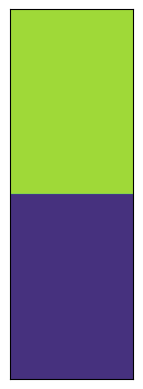

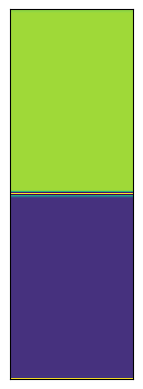

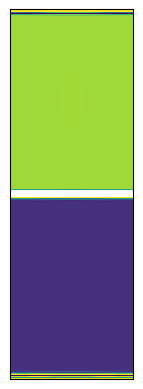

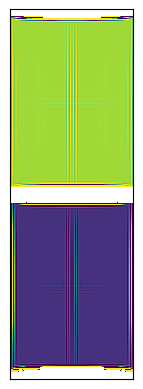

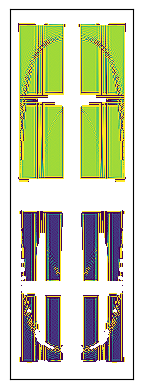

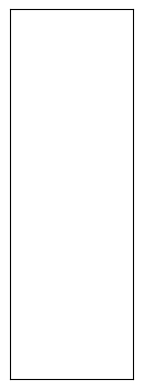

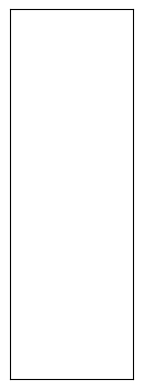

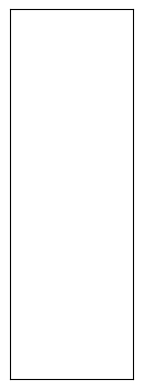

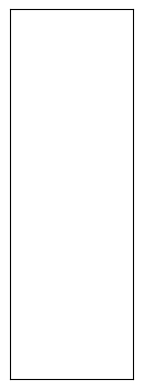

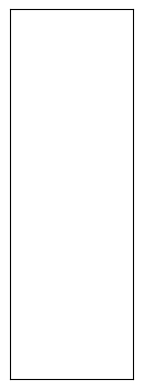

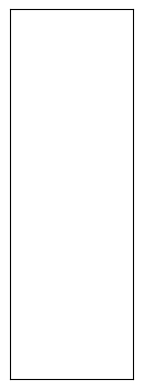

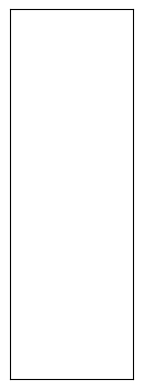

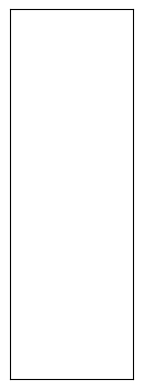

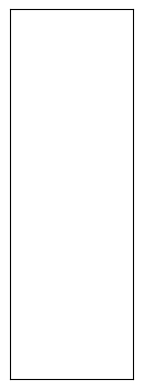

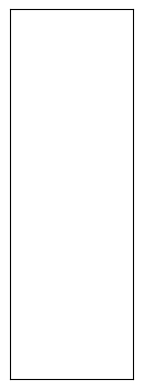

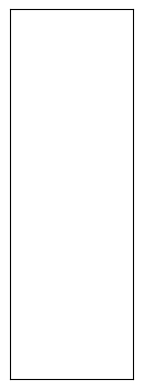

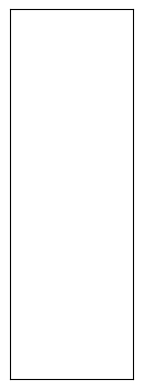

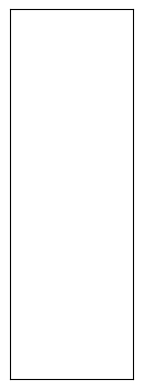

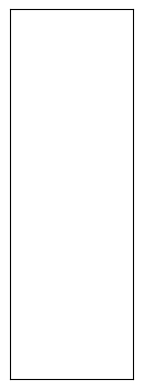

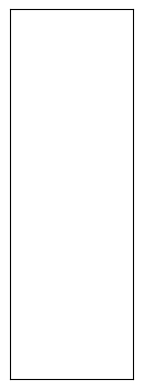

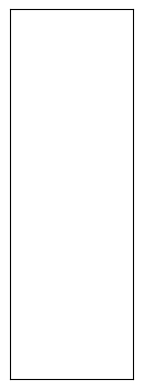

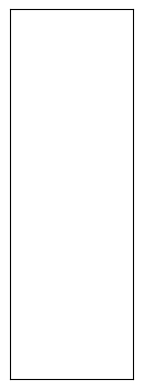

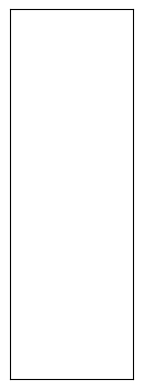

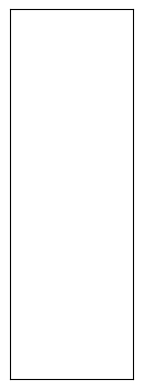

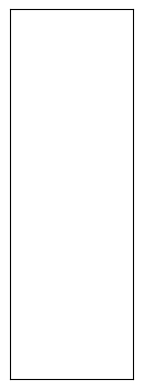

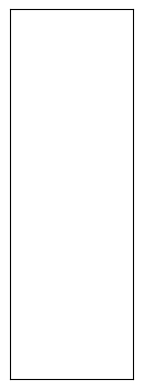

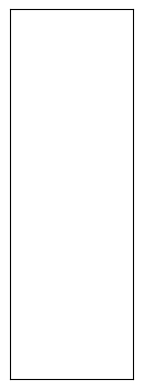

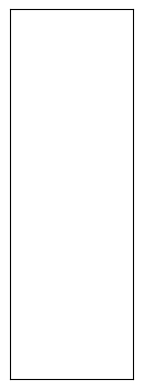

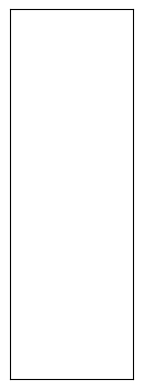

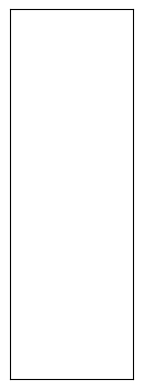

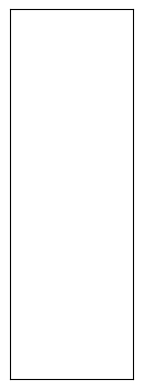

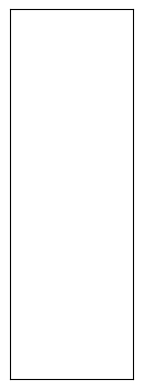

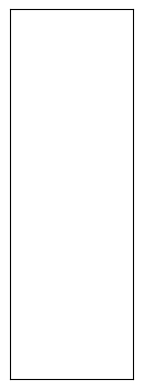

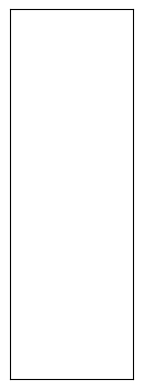

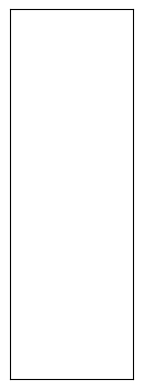

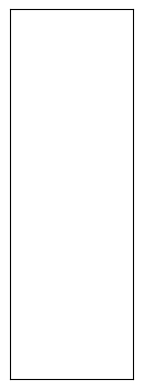

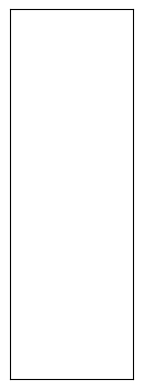

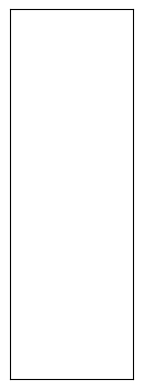

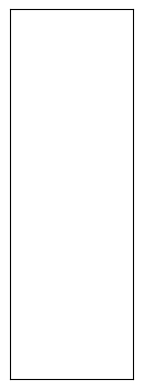

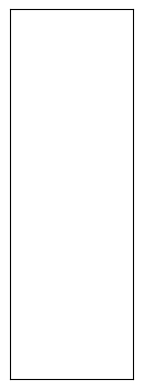

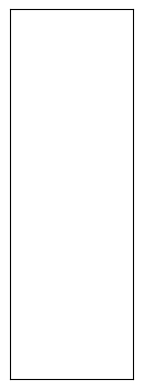

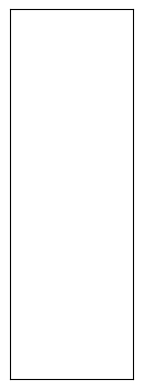

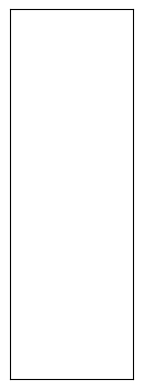

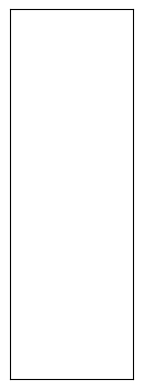

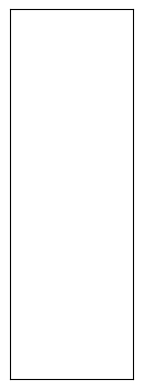

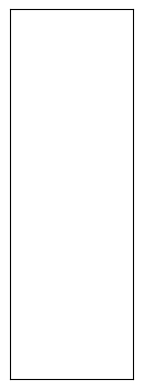

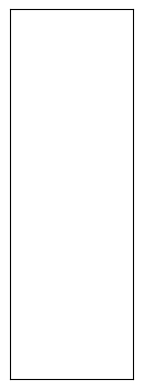

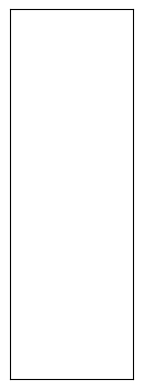

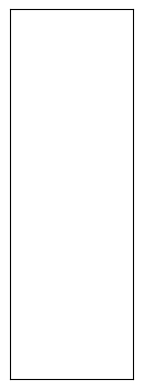

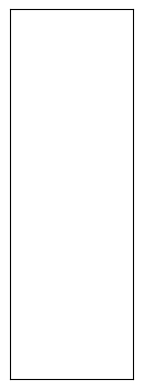

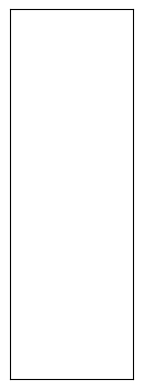

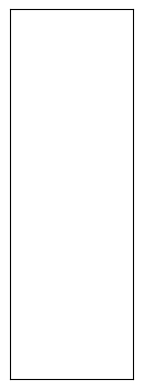

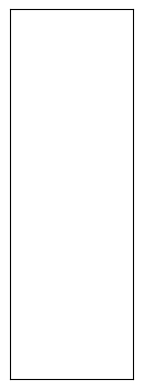

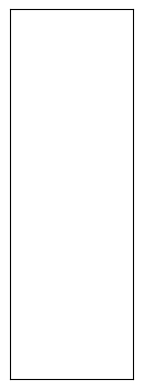

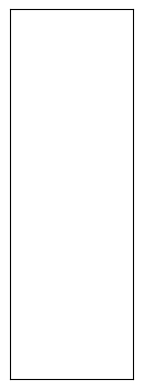

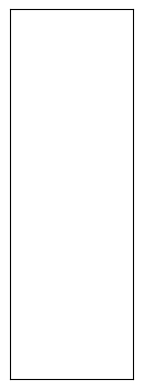

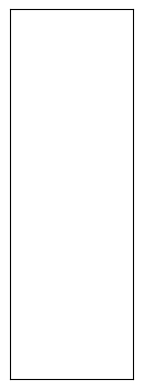

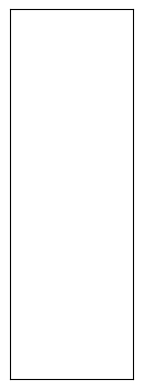

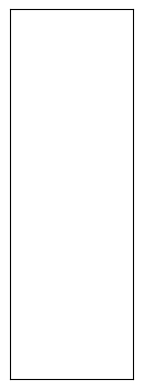

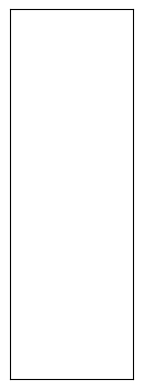

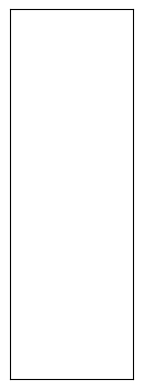

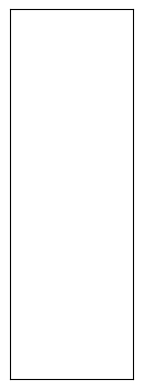

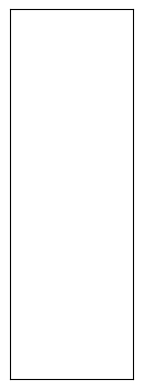

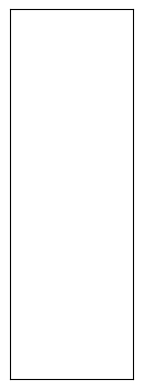

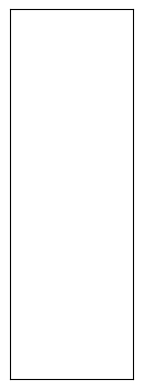

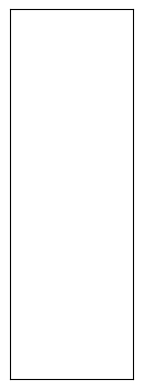

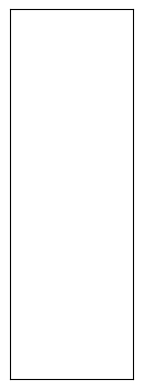

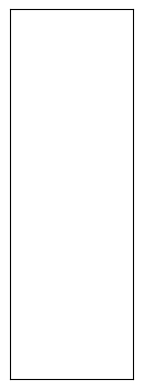

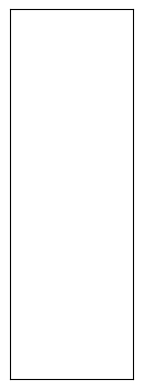

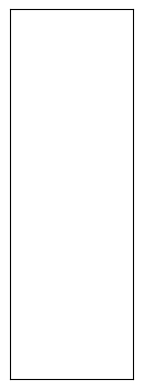

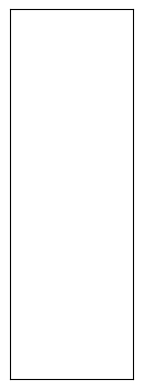

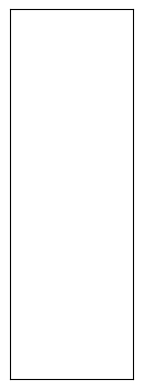

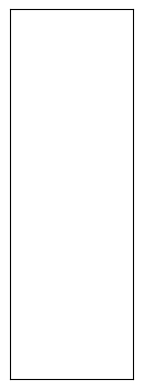

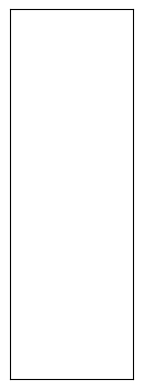

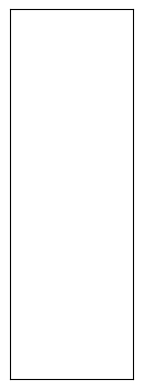

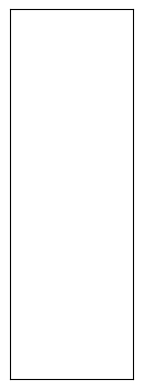

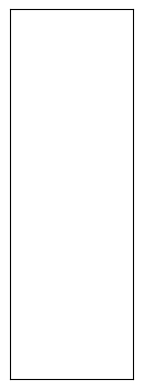

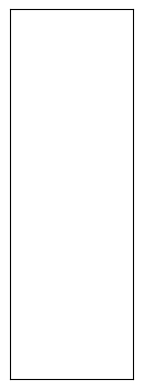

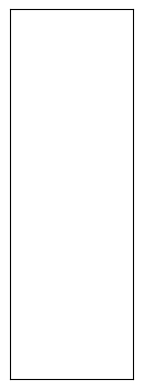

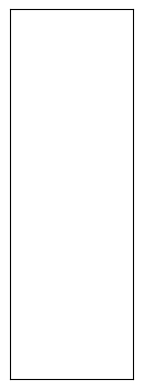

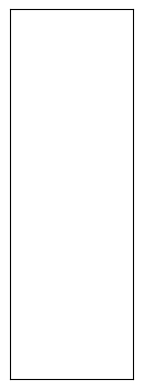

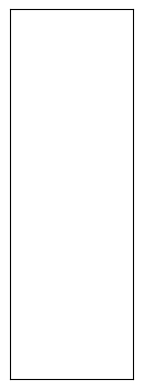

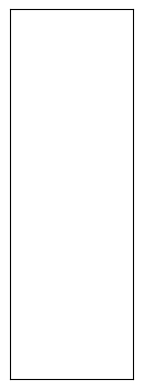

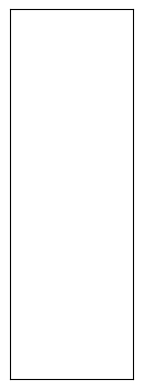

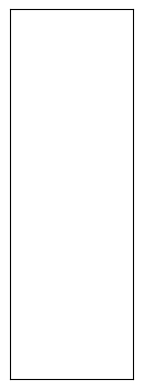

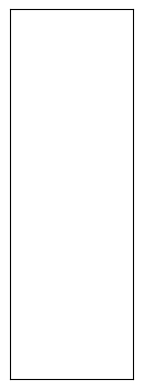

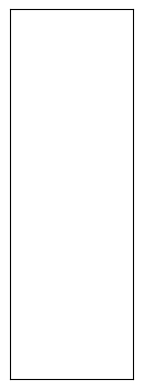

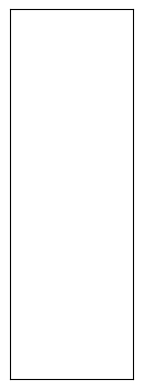

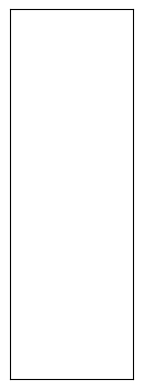

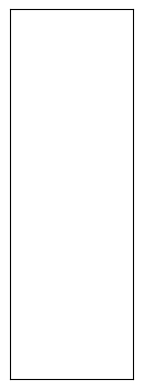

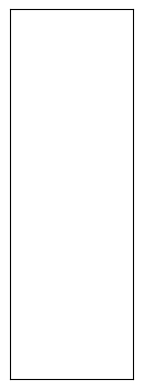

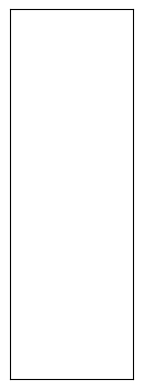

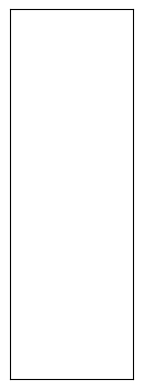

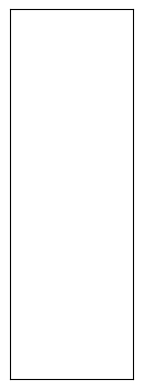

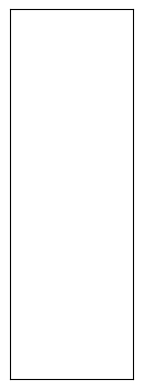

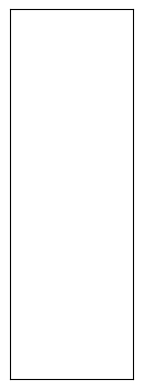

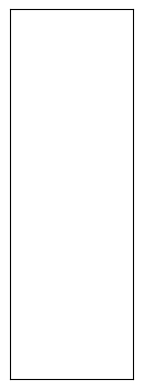

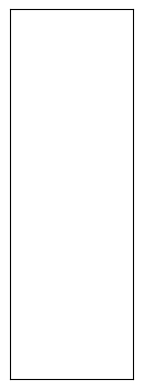

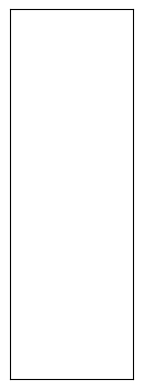

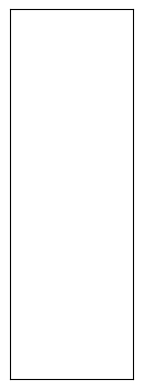

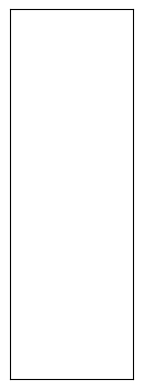

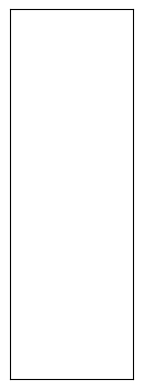

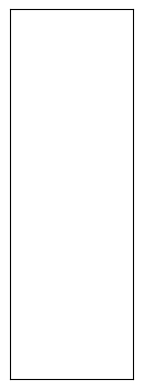

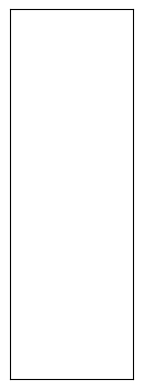

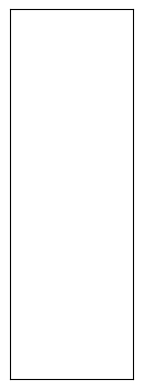

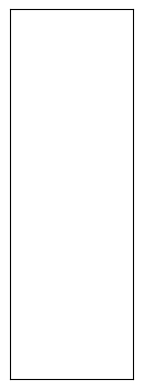

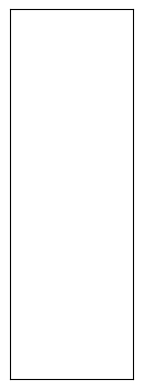

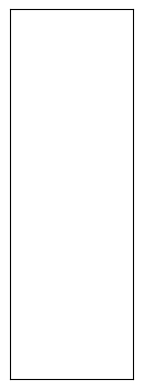

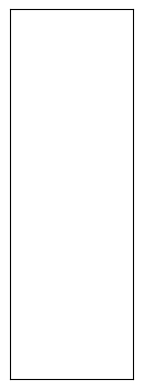

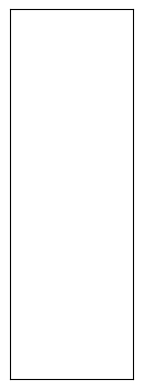

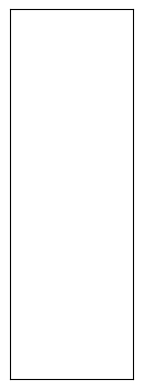

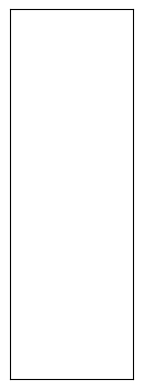

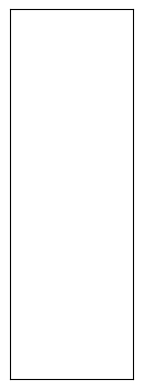

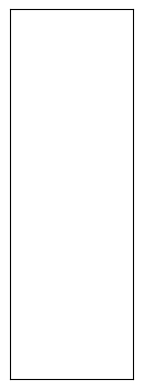

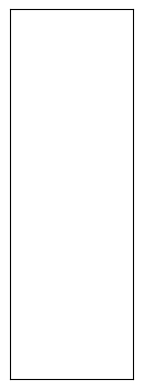

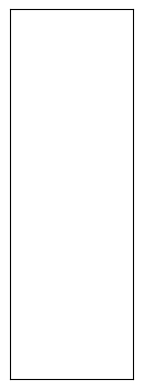

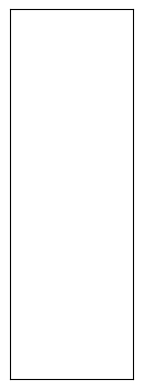

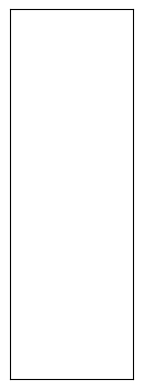

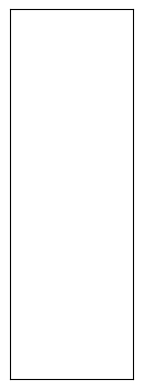

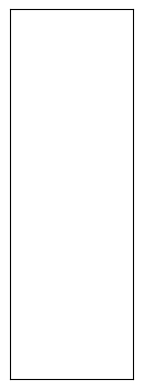

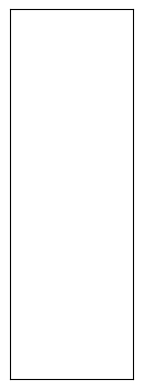

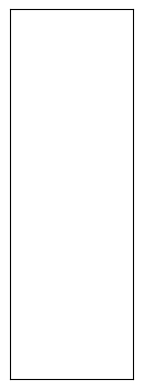

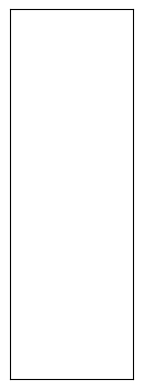

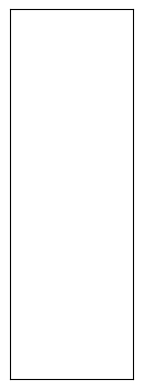

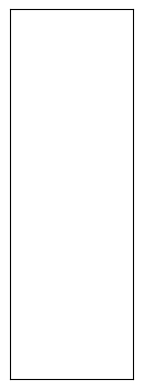

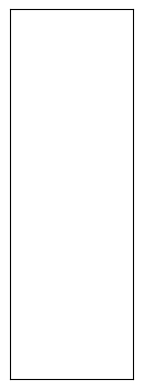

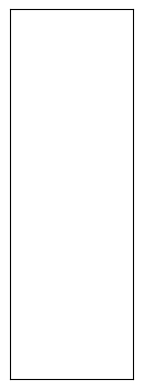

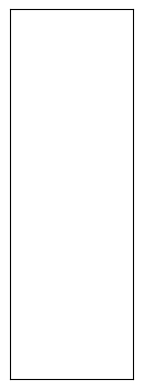

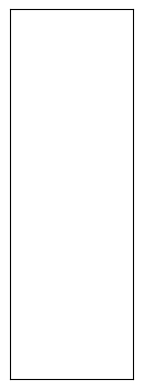

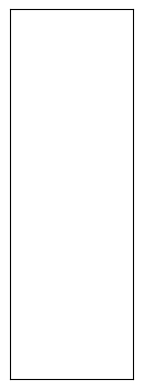

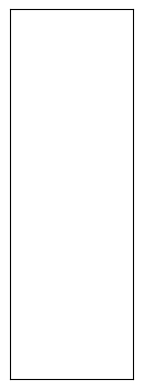

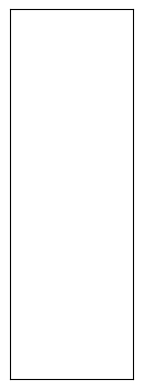

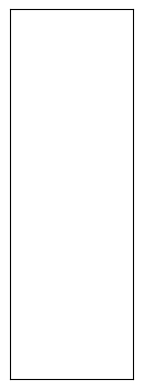

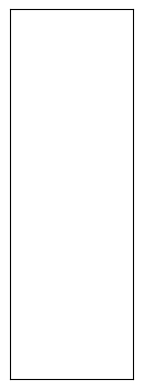

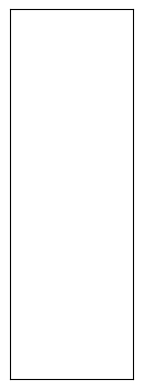

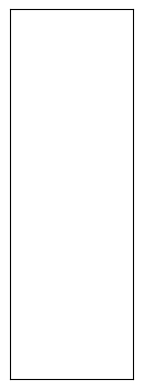

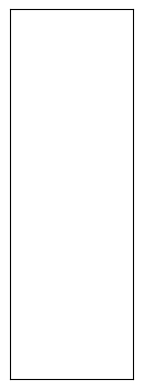

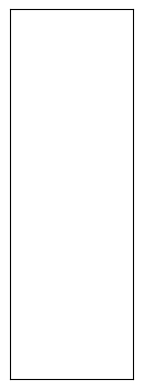

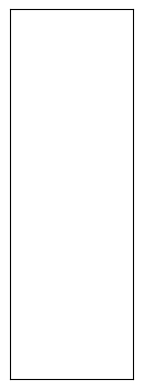

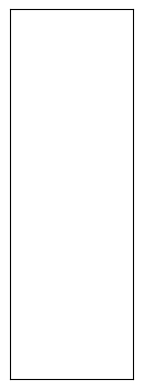

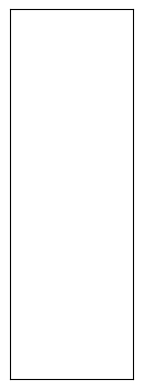

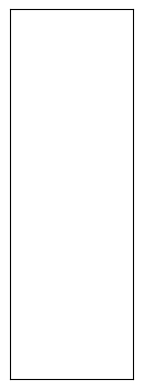

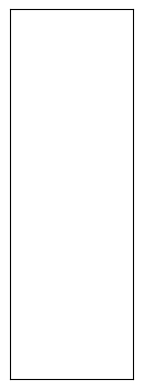

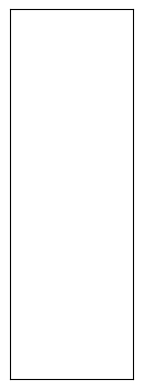

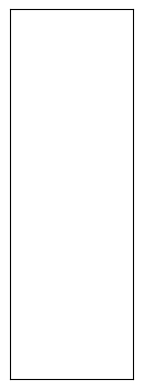

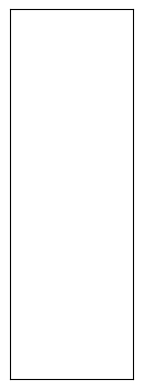

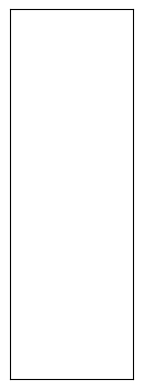

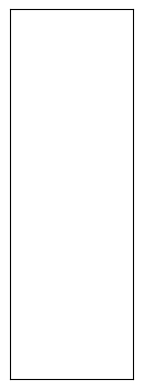

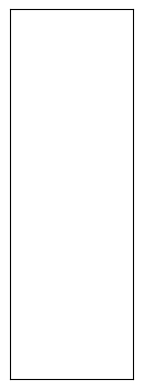

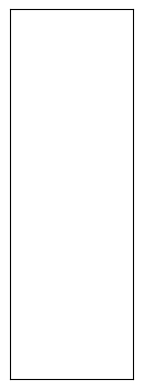

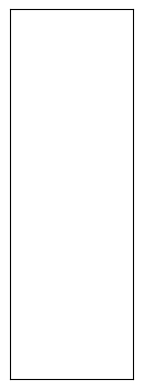

In [ ]:
i=0

while i < len(solutionRaleighTaylor):
    plt.cla()
    rho = solutionRaleighTaylor[i][0:N]
    plt.imshow(rho.T)
    plt.clim(0.8, 2.2)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i +=1
plt.show()

In [ ]:
t                      = 0   # s
tEnd                   = 2   # time at the end
tOut                   = 0.01 # time of each output

N                      = 300 # resolution
boxsize                = 2.  # in some unit system l
gamma                  = 1.4 # adiabatic index
theta                  = 1

# Define Mesh
dx = boxsize / N  # box size
dy = dx
vol = dx**2        # volume of each box
xlin = np.linspace(-0.5*(boxsize-0.5*dx), 0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

P = 2.5*np.ones(s)

w0 = 0.1
sigma = 0.05/np.sqrt(2.)
rho = 1. + (R < 0.25)
vx = -0.5 + 2*(np.abs(R) < 0.25)
vy = np.zeros(s)


Mass, Momx, Momy, E = getConserved(rho,vx,vy,P,gamma,vol)



IC = np.vstack((rho, Momx, Momy)) # here the initial conditions are stacked in a vector
solutionIsentropic, massIsentropic = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="RK4", args=(dx, dy, N, gamma, None, None, theta, Isentropic,0))

0.01/2.00
0.02/2.00
0.03/2.00
0.04/2.00
0.05/2.00
0.06/2.00
0.07/2.00
0.08/2.00
0.09/2.00
0.10/2.00
0.11/2.00
0.12/2.00
0.13/2.00
0.14/2.00
0.15/2.00
0.16/2.00
0.17/2.00
0.18/2.00
0.19/2.00
0.20/2.00
0.21/2.00
0.22/2.00
0.23/2.00
0.24/2.00
0.25/2.00
0.26/2.00
0.27/2.00
0.28/2.00
0.29/2.00
0.30/2.00
0.31/2.00
0.32/2.00
0.33/2.00
0.34/2.00
0.35/2.00
0.36/2.00
0.37/2.00
0.38/2.00
0.39/2.00
0.40/2.00
0.41/2.00
0.42/2.00
0.43/2.00
0.44/2.00
0.45/2.00
0.46/2.00
0.47/2.00
0.48/2.00
0.49/2.00
0.50/2.00
0.51/2.00
0.52/2.00
0.53/2.00
0.54/2.00
0.55/2.00
0.56/2.00
0.57/2.00
0.58/2.00
0.59/2.00
0.60/2.00
0.61/2.00
0.62/2.00
0.63/2.00
0.64/2.00
0.65/2.00
0.66/2.00
0.67/2.00
0.68/2.00
0.69/2.00
0.70/2.00
0.71/2.00
0.72/2.00
0.73/2.00
0.74/2.00
0.75/2.00
0.76/2.00
0.77/2.00
0.78/2.00
0.79/2.00
0.80/2.00
0.81/2.00
0.82/2.00
0.83/2.00
0.84/2.00
0.85/2.00
0.86/2.00
0.87/2.00
0.88/2.00
0.89/2.00
0.90/2.00
0.91/2.00
0.92/2.00
0.93/2.00
0.94/2.00
0.95/2.00
0.96/2.00
0.97/2.00
0.98/2.00
0.99/2.00
1.00/2.00


In [ ]:
i=0

while i < len(solutionIsentropic):
    plt.cla()
    rho = solutionIsentropic[i][:N].T
    plt.imshow(rho,cmap='plasma')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 1
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Conserved quantities

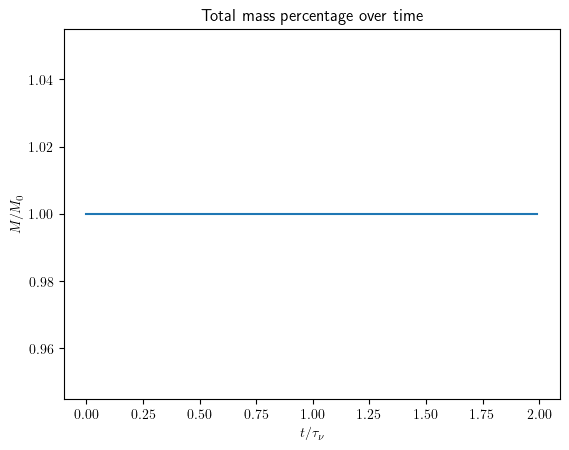

In [ ]:

plt.plot(tOut*np.array(range(len(massIsentropic))), massIsentropic/massIsentropic[0])
plt.title("Total mass percentage over time")
plt.xlabel(r"$t/\tau_{\nu}$")
plt.ylabel("$M/M_0$")
#TotalEnergy = vol*np.sum(solutionIdeal[:][3*N:])/solutionIdeal[0][3*N:]
#plt.plot(tOut*np.array(range(len(TotalEnergy))),TotalEnergy)
plt.show()

Smooth initial conditions for density with radial symmetry

In [ ]:
t                      = 0   # s
tEnd                   = 1   # time at the end
tOut                   = 0.01 # time of each output

N                      = 400 # resolution
boxsize                = 2.  # in some unit system l
gamma                  = 5/3 # adiabatic index
theta                  = 1

# Define Mesh
dx = boxsize / N  # box size
dy = dx
vol = dx**2        # volume of each box
xlin = np.linspace(-0.5*(boxsize-0.5*dx), 0.5*(boxsize-0.5*dx), N)# simulation limits

Y, X = np.meshgrid( xlin, xlin ) # define the mesh grid
s = X.shape
R = np.sqrt(X**2 + Y**2)

rho = ((1 - R**2)**4)*(R<1) + 2*np.ones(R.shape) # Mauricio`s funtion advice
vx = np.zeros(s)
vy = np.zeros(s)

IC =  np.vstack((rho, rho*vx, rho*vy))
solutionIsentropic, massIsentropic = integrator(KTschemeNonRelativisticIS, (t,tEnd), IC, tOut, method="RK4", args=(dx, dy, N, gamma, None, None, theta, Isentropic, 0))

0.01/1.00
0.02/1.00
0.03/1.00
0.04/1.00
0.05/1.00
0.06/1.00
0.07/1.00
0.08/1.00
0.09/1.00
0.10/1.00
0.11/1.00
0.12/1.00
0.13/1.00
0.14/1.00
0.15/1.00
0.16/1.00
0.17/1.00
0.18/1.00
0.19/1.00
0.20/1.00
0.21/1.00
0.22/1.00
0.23/1.00
0.24/1.00
0.25/1.00
0.26/1.00
0.27/1.00
0.28/1.00
0.29/1.00
0.30/1.00
0.31/1.00
0.32/1.00
0.33/1.00
0.34/1.00
0.35/1.00
0.36/1.00
0.37/1.00
0.38/1.00
0.39/1.00
0.40/1.00
0.41/1.00
0.42/1.00
0.43/1.00
0.44/1.00
0.45/1.00
0.46/1.00
0.47/1.00
0.48/1.00
0.49/1.00
0.50/1.00
0.51/1.00
0.52/1.00
0.53/1.00
0.54/1.00
0.55/1.00
0.56/1.00
0.57/1.00
0.58/1.00
0.59/1.00
0.60/1.00
0.61/1.00
0.62/1.00
0.63/1.00
0.64/1.00
0.65/1.00
0.66/1.00
0.67/1.00
0.68/1.00
0.69/1.00
0.70/1.00
0.71/1.00
0.72/1.00
0.73/1.00
0.74/1.00
0.75/1.00
0.76/1.00
0.77/1.00
0.78/1.00
0.79/1.00
0.80/1.00
0.81/1.00
0.82/1.00
0.83/1.00
0.84/1.00
0.85/1.00
0.86/1.00
0.87/1.00
0.88/1.00
0.89/1.00
0.90/1.00
0.91/1.00
0.92/1.00
0.93/1.00
0.94/1.00
0.95/1.00
0.96/1.00
0.97/1.00
0.98/1.00
0.99/1.00
1.00/1.00


In [ ]:
i=0
while i < len(solutionIsentropic):
    plt.cla()
    rho = solutionIsentropic[i][0:N].T
    plt.imshow(rho)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    plt.pause(0.001)
    i += 2
plt.show()

Output hidden; open in https://colab.research.google.com to view.

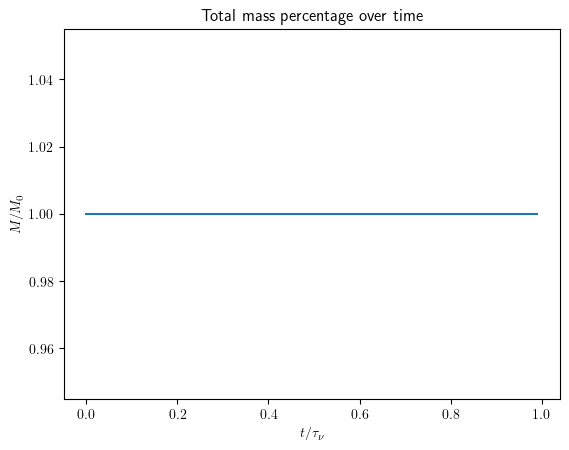

In [ ]:
plt.plot(tOut*np.array(range(len(massIsentropic))),massIsentropic/massIsentropic[0])
plt.title("Total mass percentage over time")
plt.xlabel(r"$t/\tau_{\nu}$")
plt.ylabel(r"$M/M_0$")
#TotalEnergy = vol*np.sum(solutionIdeal[:][3*N:])/solutionIdeal[0][3*N:]
#plt.plot(tOut*np.array(range(len(TotalEnergy))),TotalEnergy)
plt.show()

In [ ]:

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - data.shape[0]*center[0])**2 + (y - data.shape[1]*center[1])**2)
    r = r.astype(np.int64)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

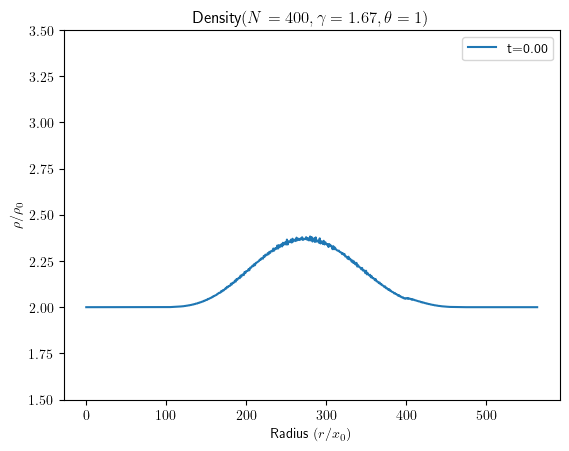

In [ ]:
i=0

rho_radial = radial_profile(solutionIsentropic[i][:N],np.array((0,0)))
ur_radial = radial_profile(np.sqrt((solutionIsentropic[i][N:2*N] / solutionIsentropic[i][:N])**2 + (solutionIsentropic[i][2*N:3*N] / solutionIsentropic[i][:N])**2),np.array((0,0)))
uphy_radial = radial_profile((X[:][int(N/2)]*(solutionIsentropic[i][2*N:3*N] / solutionIsentropic[i][:N]) - Y[:][int(N/2)]*(solutionIsentropic[i][N:2*N] / solutionIsentropic[i][:N]))/(R[:][int(N/2)]),np.array((0,0)))

plt.ylim(1.5,3.5)
plt.plot(rho_radial, label='t={:.2f}'.format(tOut*i))
plt.title(r'Density$(N = {}, \gamma = {:.2f}, \theta = {})$'.format(N,gamma,theta))
plt.xlabel(r"Radius $(r/x_0)$")
plt.ylabel(r"$\rho/\rho_0$")
plt.legend()
plt.show()

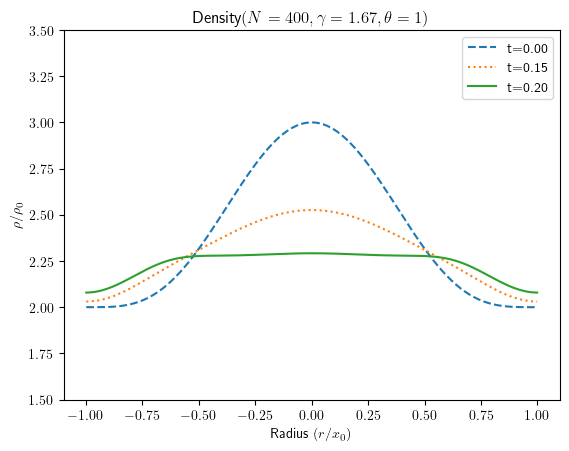

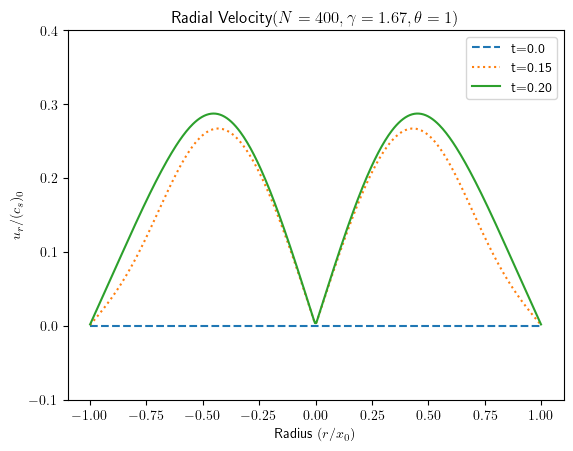

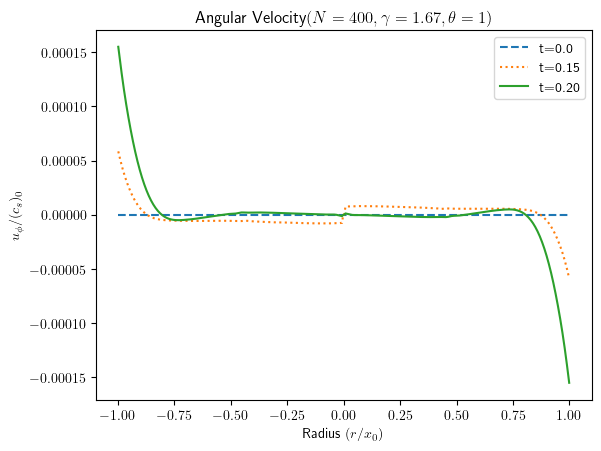

In [ ]:

i=0
k=15
j=20


# slice through the center horizontally

rho = (solutionIsentropic[i][:N])[int(N/2)]
ux = solutionIsentropic[i][N:2*N][int(N/2)] / rho
uy = solutionIsentropic[i][2*N:3*N][int(N/2)] / rho

rhosharp = (solutionIsentropic[k][:N])[int(N/2)]
uxsharp = solutionIsentropic[k][N:2*N][int(N/2)] / rhosharp
uysharp = solutionIsentropic[k][2*N:3*N][int(N/2)] / rhosharp

rhoprime = (solutionIsentropic[j][:N])[int(N/2)]
uxprime = solutionIsentropic[j][N:2*N][int(N/2)] / rhoprime
uyprime = solutionIsentropic[j][2*N:3*N][int(N/2)] / rhoprime

ur = np.sqrt(ux**2 + uy**2)
ursharp = np.sqrt(uxsharp**2 + uysharp**2)
urprime = np.sqrt(uxprime**2 + uyprime**2)

uphy = (X[:][int(N/2)]*uy - Y[:][int(N/2)]*ux)/(R[:][int(N/2)])
uphysharp = (X[:][int(N/2)]*uysharp - Y[:][int(N/2)]*uxsharp)/(R[:][int(N/2)])
uphyprime = (X[:][int(N/2)]*uyprime - Y[:][int(N/2)]*uxprime)/(R[:][int(N/2)])


plt.ylim(1.5,3.5)
plt.plot(xlin,rho, label='t=0.00', linestyle='dashed' )
plt.plot(xlin,rhosharp, label='t={:.2f}'.format(tOut*k), linestyle='dotted')
plt.plot(xlin,rhoprime, label='t={:.2f}'.format(tOut*j))
plt.title(r'Density$(N = {}, \gamma = {:.2f}, \theta = {})$'.format(N,gamma,theta))
plt.xlabel(r"Radius $(r/x_0)$")
plt.ylabel(r"$\rho/\rho_0$")
plt.legend()
plt.show()

plt.ylim(-0.1,0.4)
plt.plot(xlin,ur, label='t=0.0', linestyle='dashed')
plt.plot(xlin,ursharp, label='t={:.2f}'.format(tOut*k), linestyle='dotted')
plt.plot(xlin,urprime, label='t={:.2f}'.format(tOut*j))
plt.title(r'Radial Velocity$(N = {}, \gamma = {:.2f}, \theta = {})$'.format(N,gamma,theta))
plt.xlabel(r"Radius $(r/x_0)$")
plt.ylabel(r"$u_r/(c_s)_0$")
plt.legend()
plt.show()

plt.plot(xlin,uphy, label='t=0.0', linestyle='dashed')
plt.plot(xlin,uphysharp, label='t={:.2f}'.format(tOut*k), linestyle='dotted')
plt.plot(xlin,uphyprime, label='t={:.2f}'.format(tOut*j))
plt.title(r'Angular Velocity$(N = {}, \gamma = {:.2f}, \theta = {})$'.format(N,gamma,theta))
plt.xlabel(r"Radius $(r/x_0)$")
plt.ylabel(r"$u_{\phi}/(c_s)_0$")
plt.legend()
plt.show()